# **Classification garbage**

- **NOTE:** This notebook was executed on Google Colab

In [1]:
from IPython.display import Image
from IPython import display

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

plt.style.use("ggplot")

In [2]:
from google.colab import drive

# Connect to Google Drive to retrieve the data
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# Number of images per folder
path = "/content/drive/MyDrive/labelled_data"
splits = ["train", "val", "test"]
targets = ["clean", "dirty"]

for split in splits:
  print("---")
  for target in targets:
    n = len(os.listdir(f"{path}/{split}/{target}"))
    print(f"{split}/{target}: {n} images")

---
train/clean: 100 images
train/dirty: 100 images
---
val/clean: 50 images
val/dirty: 50 images
---
test/clean: 200 images
test/dirty: 200 images


#### **1. Data labelling**

- **Overview**
  - We first observed the labelled images in the train set to familiarize with the data
  - We then tried to classify the unlabelled images in the test set
  - Going through each of them, if the target is clear, we move the image to the appropriate folder
  - In case of doubt, we ran into an iterative process:
    - Keep the concerned images aside
    - Figure out which ones can be classified correctly with some certainty, considering the number of missing samples in each group
    - Add the selected images to the target folders
  - At a certain point we had a great challenge with some confusing images
  - In a real use case, we would have discussed with different people to validate this entire labeling process

- **Labelling details**
  - We have 2 classes: `clean` and `dirty`
  - FOR EACH of them, we have the following splits:
    -  `train`:
      - 20 labelled samples
      - 280 unlabelled samples
    -  `test`: 50 unlabelled samples, we labelled them
    - The 280 unlabelled samples were all labelled and exploited this way:
      - 50 samples were picked for the validation set to asses the model's performance during training
      - 80 samples were added to the train set to provide more data to the model during training
      - The rest (150) were added to the test set
    - As previously said, some images were very hard to classify visually, this work assumes we have correctly identified the labels
    - For reproducibility, the classified images file names are saved in text files: `train|val|test/clean|dirty.txt`

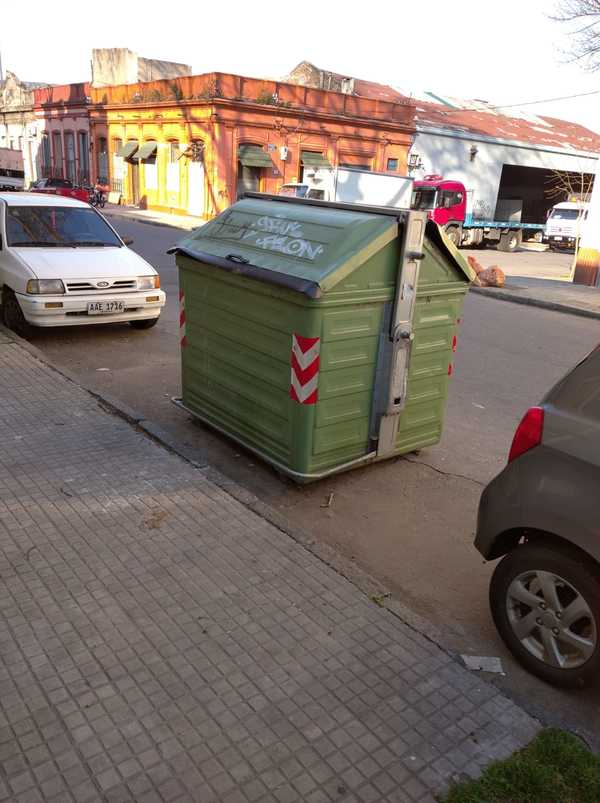

In [4]:
# A clean garbage
Image(filename="/content/drive/MyDrive/labelled_data/train/clean/0e02598e-acbb-423e-912e-cf2b922b5bd7.jpeg", width=300)

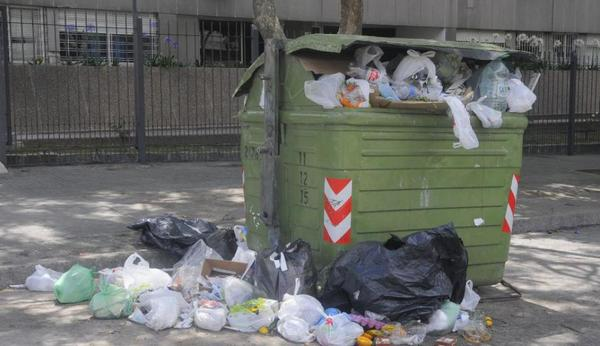

In [5]:
# A dirty garbage
Image(filename="/content/drive/MyDrive/labelled_data/train/dirty/59b578137fcbe.jpeg", width=300)

#### **2. Train a classification model on the data**

-  **Model**
   - We are going to train a YOLO model (v11) from [Ultralytics](https://docs.ultralytics.com/) on a classification task
   - It achieves state-of-the-art performance accros multiple tasks
   - Generally, the images don't need any prior manual processing
- **Evaluation**
  - We expect to achieve a "high" (undefined) score on the binary classification metrics (accuracy, precision, recall, and AUC)
  - In this use case, we assume that a "dirty" prediction on an image will alert a garbage collector to remove the dirt
  - Therefore, we think it's more suitable to trigger some false alarms ("clean" garbage predicted as "dirty"), than missing a really full garbage can ("dirty" classified as "clean")
  - Considering "clean" as 0, and "dirty" as 1, we want to find a classification threshold that maximises the recall while having "acceptable performance"

In [6]:
# Install ultralytics to use YOLO
!pip install ultralytics

display.clear_output()

In [7]:
# Import YOLO
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
# Delete training results if they exist
!rm -rf /content/runs/classify/train

In [9]:
# Load a pretrained classification model (medium size)
model = YOLO("yolov8m-cls.pt")

# Train the model
model.train(
    data="/content/drive/MyDrive/labelled_data",
    epochs=20, seed=42, imgsz=640, dropout=0.8,
)

display.clear_output()

#### **3. Evaluation**

In [10]:
# The training results
train_results = pd.read_csv("/content/runs/classify/train/results.csv")
train_results.head()

,epoch,time,train/loss,metrics/accuracy_top1,metrics/accuracy_top5,val/loss,lr/pg0,lr/pg1,lr/pg2
0,1,19.0044,0.80135,0.55,1,0.71948,0.000086,0.000086,0.000086
1,2,35.5361,0.69074,0.65,1,0.64355,0.000170,0.000170,0.000170
2,3,53.0635,0.67205,0.77,1,0.57397,0.000244,0.000244,0.000244
3,4,71.4363,0.58412,0.83,1,0.52454,0.000310,0.000310,0.000310
4,5,89.4416,0.49506,0.84,1,0.50311,0.000366,0.000366,0.000366


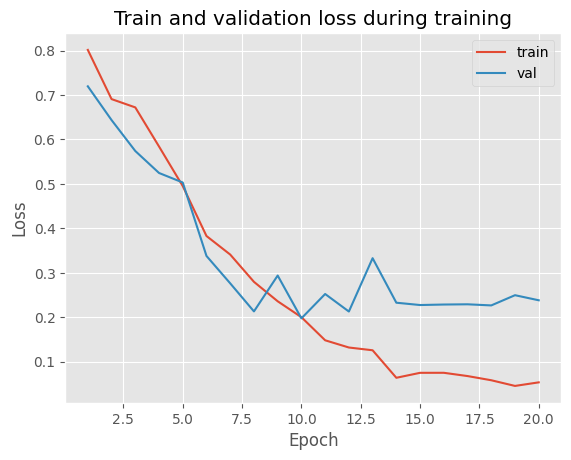

In [11]:
# Plot train and validation loss
plt.plot(train_results["epoch"], train_results["train/loss"], label="train")
plt.plot(train_results["epoch"], train_results["val/loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and validation loss during training")
plt.legend()
plt.show()

- After some experiments, this is the more reliable model we've obtained
- With more epochs, or the default image size or no drop out, the model starts memorizing the training data while being very bad on the validation set (overfitting)
- With much more work, maybe we could have further reduced the loss on the validation data (new ideas are welcome)

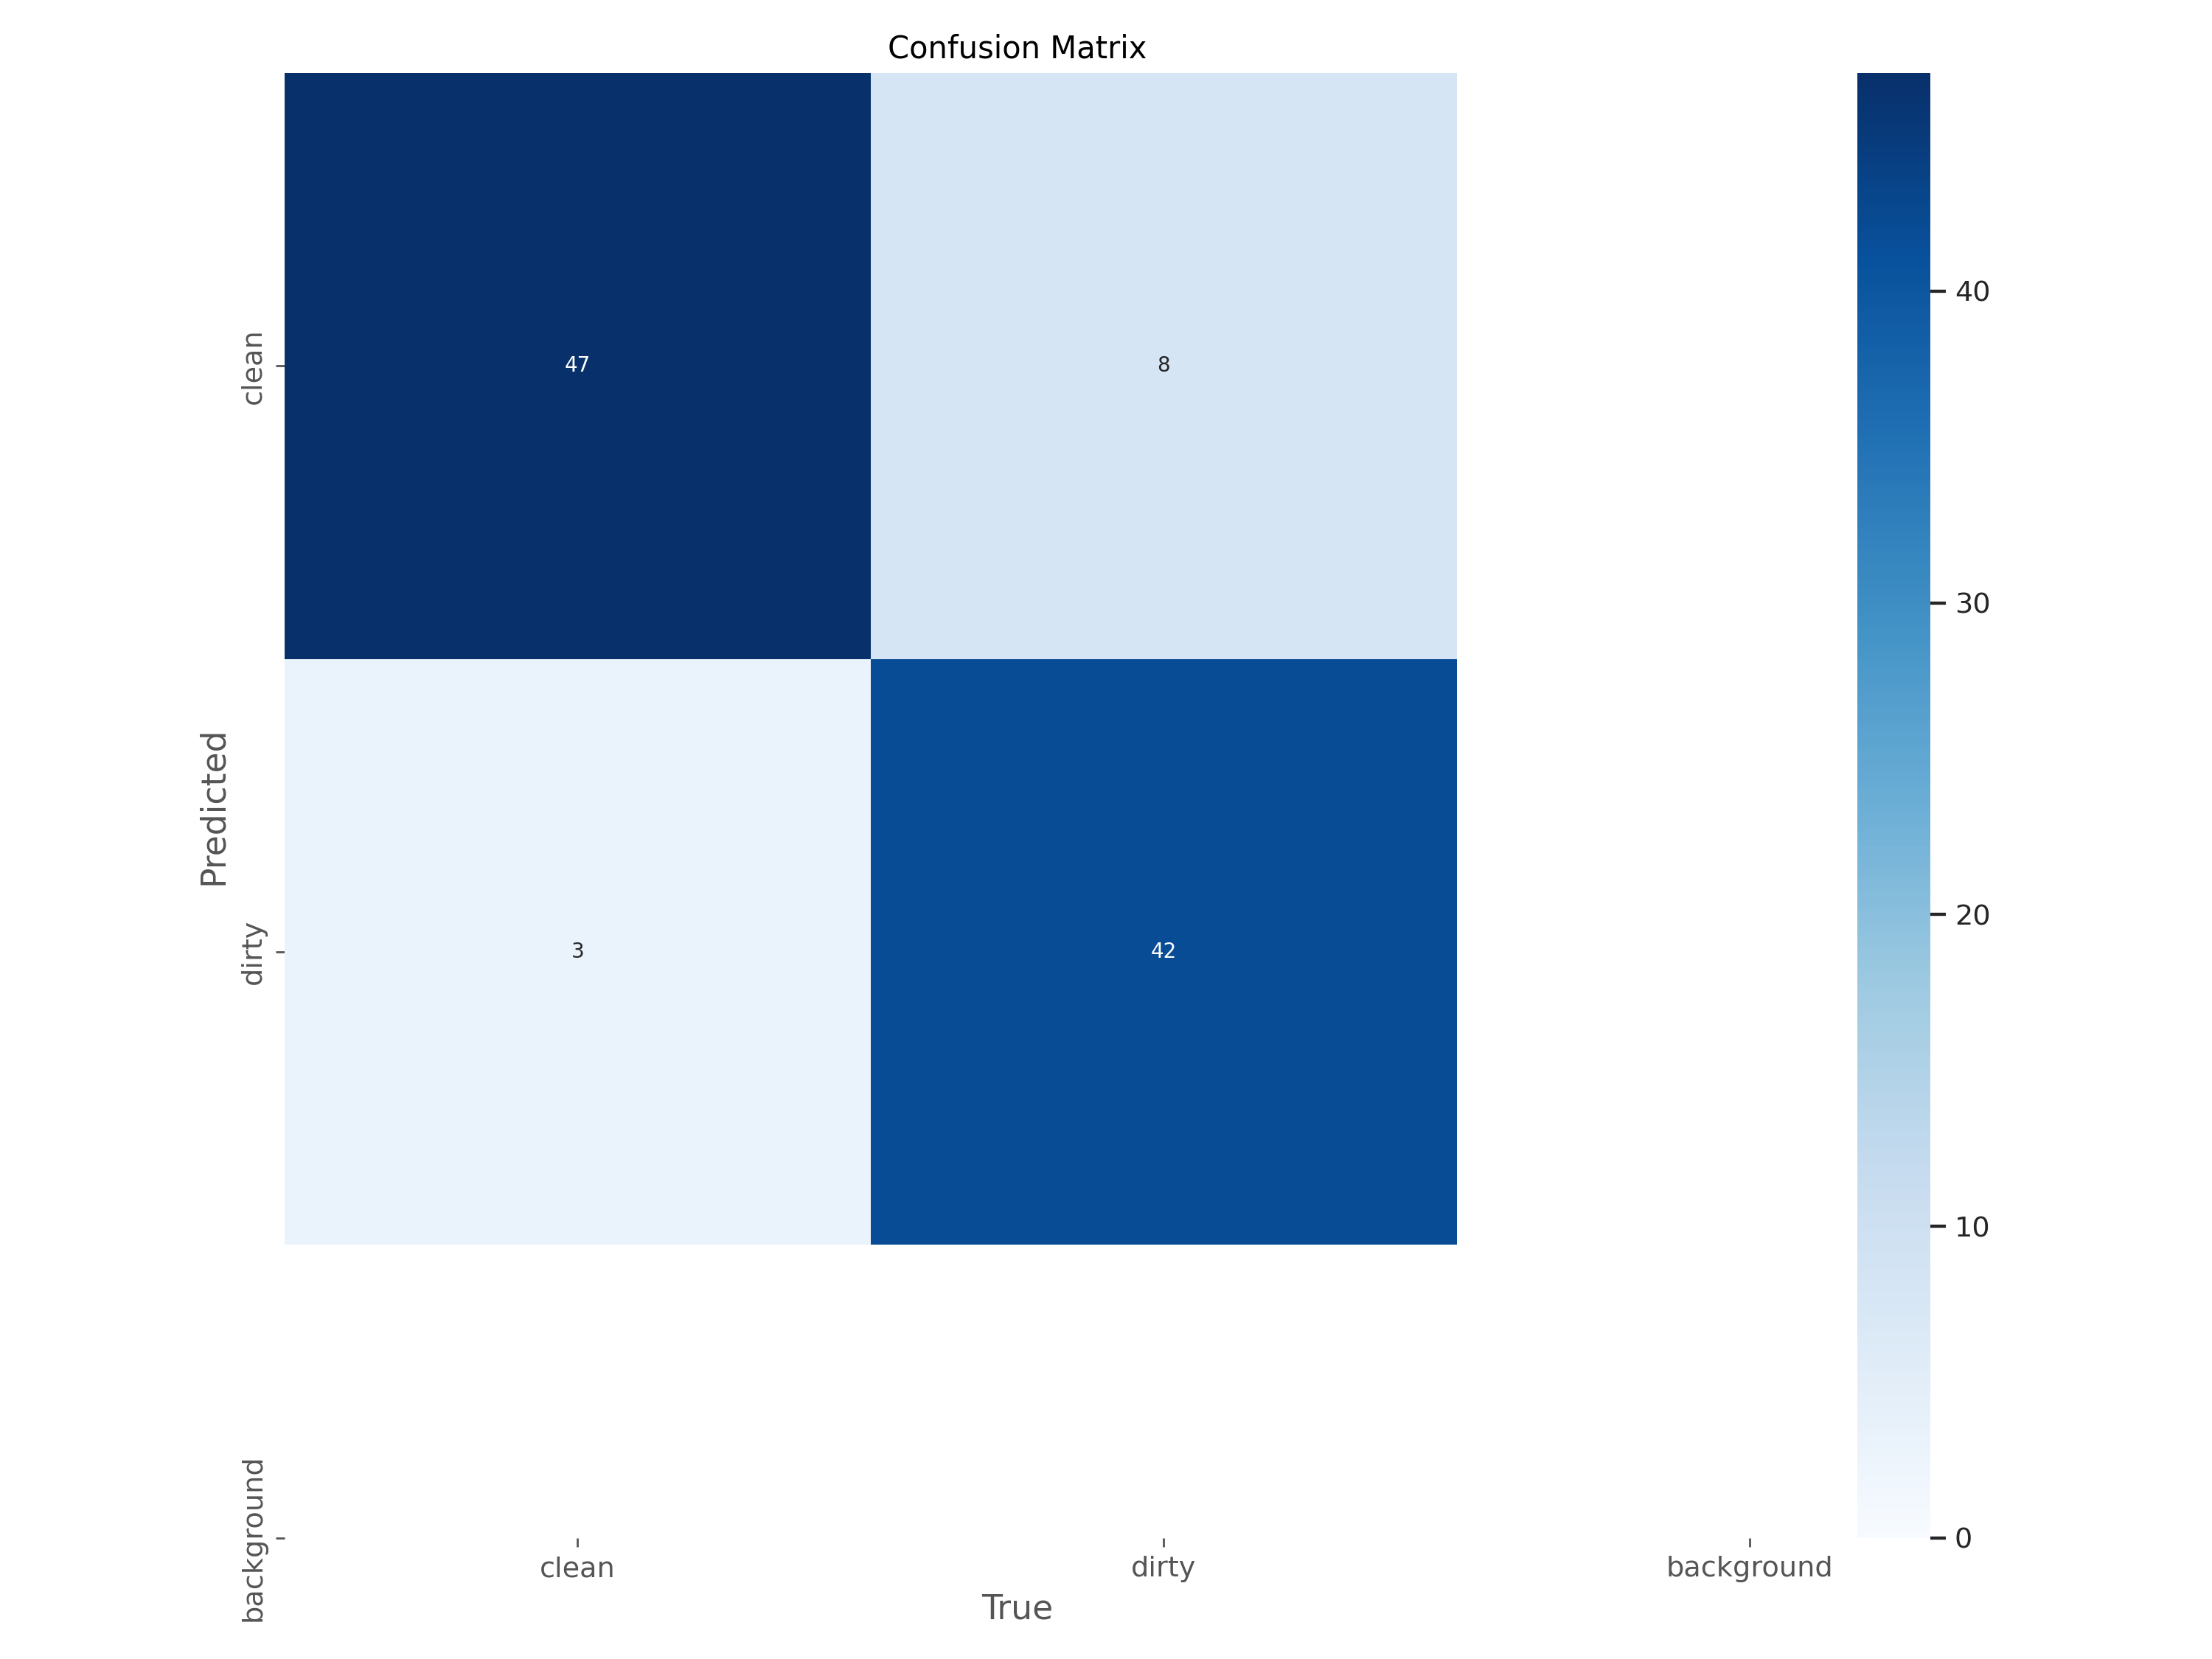

In [12]:
# The confusion matrix on the validation data
Image(filename="/content/runs/classify/train/confusion_matrix.png", width=600)

- The confusion matrix on the validation set shows that the model makes more false negative errors, i.e. dirty garbage cans detected as clean (8 vs. 3 false positive)
- Unfortunately that's what we expected to avoid
- Let's test the model on more data to better analyze the situation

#### **4. Inference**

In [13]:
# Target ids to class names
targets_map_dict = model.names
targets_map_dict

{0: 'clean', 1: 'dirty'}

In [14]:
# Run the trained model on test data
pred_clean = model("/content/drive/MyDrive/labelled_data/test/clean")
pred_dirty = model("/content/drive/MyDrive/labelled_data/test/dirty")

display.clear_output()

In [15]:
# Extract the predictions
pred_raw = pred_clean + pred_dirty
pred = [json.loads(p.to_json())[0] for p in pred_raw]
pred = [p["class"] for p in pred]

In [16]:
# Classification metrics
actual = []
actual.extend([0] * len(pred_clean))
actual.extend([1] * len(pred_dirty))

print(classification_report(actual, pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       200
           1       0.92      0.78      0.84       200

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



- As reported previously, this classificator is very likely to not noticing 22% of full garbage cans (recall on class 1 = 78%), while achieving an overall accuracy of 85%
- It can be interesting to focus on the specific images the model fails to classify to further understand its limits

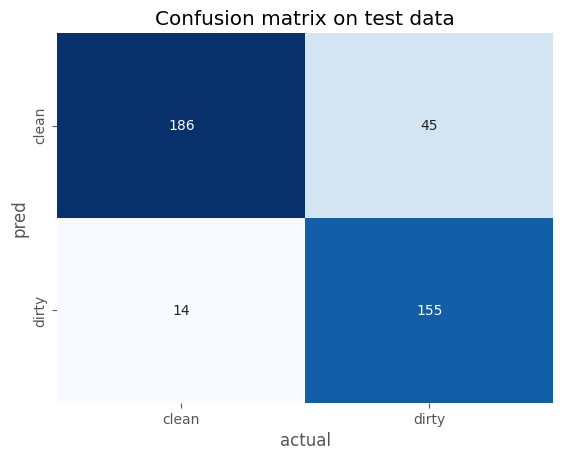

In [17]:
# Plot the confusion matrix
data = {"pred": pred, "actual": actual}
test_df = pd.DataFrame(data)
test_df.replace(targets_map_dict, inplace=True)  # ids to class names

cm = pd.crosstab(test_df["pred"], test_df["actual"])
sns.heatmap(cm, cmap="Blues", annot=True, fmt="d", cbar=False)
plt.title("Confusion matrix on test data")
plt.show()

##### **- Draw the ROC curve: this can help choosing another threshold than 0.5 to define the classes**

- I wanted to do it a bit by hand for a bit of fun!

In [18]:
# For each result, get the probability to have a positive prediction (dirty)
dirty_prob = np.array([float(p.probs.data[1]) for p in pred_raw])

In [19]:
# For a given threshold, compute the new predictions
# Eg. For the default value (0.5)
threshold = 0.5
thresh_pred = list(dirty_prob >= threshold)  # 0: clean, 1: dirty

# Check if these predictions match with the model's predictions
pred == thresh_pred

True

In [20]:
# Remember, we have the actual predictions
actual[0], actual[-1]

(0, 1)

In [21]:
# Save the results in a df for better handling
data = {
    "thresh_pred": thresh_pred,
    "actual": actual,
}

thresh_df = pd.DataFrame(data)

# Add TP, TN, FP, and FN colums
thresh_df["TP"] = thresh_df["thresh_pred"] & thresh_df["actual"]
thresh_df["TN"] = ~thresh_df["thresh_pred"] & ~thresh_df["actual"]
thresh_df["FP"] = thresh_df["thresh_pred"] & ~thresh_df["actual"]
thresh_df["FN"] = ~thresh_df["thresh_pred"] & thresh_df["actual"]

# Verification: each row is exactly in one of those cases
(thresh_df[["TP", "TN", "FP", "FN"]].sum(axis=1) == 1).all()

True

In [22]:
# FPR and TPR
FPR = thresh_df["FP"].sum() / (thresh_df["TN"].sum() + thresh_df["FP"].sum())
TPR = thresh_df["TP"].sum() / (thresh_df["TP"].sum() + thresh_df["FN"].sum())

print(f"FPR: {FPR}")
print(f"TPR: {TPR}")

FPR: 0.07
TPR: 0.775


In [23]:
# Encapsulate everything in a function
def compute_fpr_tpr(dirty_prob, actual, threshold):
  # Predictions with regards to the choosen threshold
  thresh_pred = list(dirty_prob >= threshold)  # 0: clean, 1: dirty

  # Save the results in a df for better handling
  data = {
      "thresh_pred": thresh_pred,
      "actual": actual,
  }

  thresh_df = pd.DataFrame(data)

  # Add TP, TN, FP, and FN colums
  thresh_df["TP"] = thresh_df["thresh_pred"] & thresh_df["actual"]
  thresh_df["TN"] = ~thresh_df["thresh_pred"] & ~thresh_df["actual"]
  thresh_df["FP"] = thresh_df["thresh_pred"] & ~thresh_df["actual"]
  thresh_df["FN"] = ~thresh_df["thresh_pred"] & thresh_df["actual"]

  # FPR and TPR
  fpr = thresh_df["FP"].sum() / (thresh_df["TN"].sum() + thresh_df["FP"].sum())
  tpr = thresh_df["TP"].sum() / (thresh_df["TP"].sum() + thresh_df["FN"].sum())

  # Add precision (can help decide when looking for a new threshold)
  # Recall = FPR
  if threshold != np.inf:
    pr = thresh_df["TP"].sum() / (thresh_df["TP"].sum() + thresh_df["FP"].sum())
  else:
    pr = 1

  return fpr, tpr, pr

In [24]:
# Thresholds ranges from minimum to maximum of the positive class probabilities
# We add +inf after the maximum to enforce FPR and TPR to have a zero value:
# if threshold = max_prob, then the positive class has at least 1 element (>=)
# No need to add -inf: if threshold = min_prob, FPR = TPR = 1 (all preds = 1)
# We start with the highest threshold values to have increasing FPR and TPR

# Run the function for many thresholds
thresholds = np.linspace(dirty_prob.max(), dirty_prob.min(), 49)
thresholds = [np.inf] + list(thresholds)
fpr_tpr = [compute_fpr_tpr(dirty_prob, actual, threshold) for threshold in thresholds]

# Unpack the values
fpr, tpr, pr = zip(*fpr_tpr)

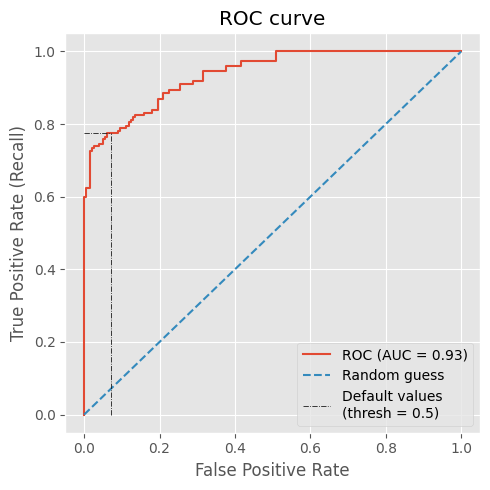

In [25]:
# Compute the AUC (trapezoidal integral approximation)
# -> x (fpr): iteratively get the interval length (substraction)
# -> y (tpr): iteratively get the average height (sum / 2)
# -> sum all areas (x*y)
x = np.diff(fpr)
y = (np.array(tpr)[:-1] + np.array(tpr)[1:]) / 2
auc = sum(x*y)

# Draw the ROC curve
plt.figure(figsize=(5, 5))

# ROC
plt.step(fpr, tpr, label=f"ROC (AUC = {auc:.2f})")

# Random guess (very bad model)
plt.plot([0, 1], [0, 1], ls="--", label="Random guess")

# Locate the default situation on the graph (threshold = 0.5)
# -> id is the index of the list element that's closest to 0.5
id = abs(np.array(thresholds) - 0.5).argmin()

threshold_def = thresholds[id]
fpr_def = fpr[id]
tpr_def = tpr[id]

# -> Default situation lines
plt.vlines(fpr_def, 0, tpr_def, ls="-.", lw=0.6, color="k")
plt.hlines(tpr_def, 0, fpr_def, ls="-.", lw=0.6, color="k",
           label="Default values\n(thresh = 0.5)")

# Styling stuff
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

- To better identify dirty garbage cans, we can adjust our classification threshold to "tolerate" more images in the "dirty" category
- Of course, this implies that some really clean garbage cans could be mistakenly classified in this category
- For example, if we want to detect 80% of dirty garbage cans (instead of the current 77.5%), the following combination might be appropriate

In [26]:
print(f"Default threshold: ~{thresholds[id]:.4f}")
print(f"Recall: ~{tpr[id]:.4f}")
print(f"Precision: ~{pr[id]:.4f}")
print("---")

new_id = 34
print(f"New threshold: {thresholds[new_id]:.4f}")
print(f"Recall: {tpr[new_id]:.4f}")
print(f"Precision: {pr[new_id]:.4f}")

Default threshold: ~0.5000
Recall: ~0.7750
Precision: ~0.9172
---
New threshold: 0.3125
Recall: 0.8050
Precision: 0.8656


- Now it's up to the teams to discuss 😄